# Assignment — Structural similairy

In [119]:
from scipy.sparse import csr_matrix
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from networkx.algorithms.link_prediction import jaccard_coefficient 
import pandas as pd
from scipy.sparse.csgraph import reverse_cuthill_mckee
from networkx.algorithms.assortativity import attribute_mixing_matrix
import networkx as nx
import numpy as np

### Task 1. Similarity measures (4 points)

In this section we will look at how nodes can be similar to each other. We will consider the movie co-watch dataset. The dataset is builded based on the MovieLens-100k data. The films have links between when one user gives them the highest rate and watch both.

In [3]:
url = "https://raw.githubusercontent.com/netspractice/network-science/main/datasets/movies.gml"
open('movie-cowatch.gml', 'wb').write(requests.get(url).content)
G = nx.read_gml('movie-cowatch.gml')
G = nx.convert_node_labels_to_integers(G)

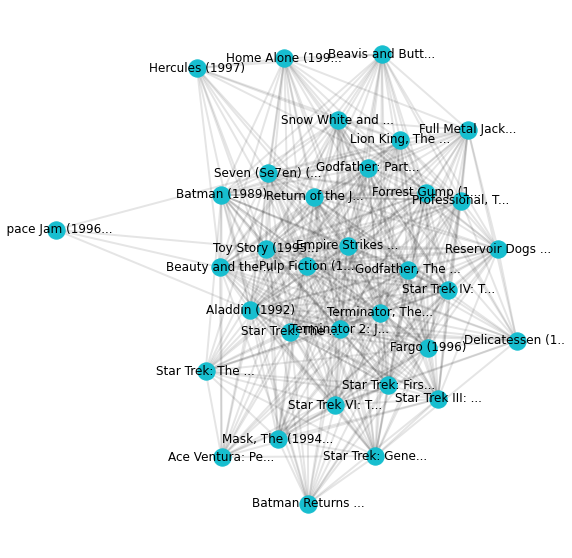

In [4]:
labs = nx.get_node_attributes(G, "movieName")
labs = {i:labs[i][:15] if len(labs[i])<=15 else labs[i][:15] + '...' for i in labs}
plt.figure(figsize=(10, 10))
plt.gca().axis('off')

pos = nx.kamada_kawai_layout(G)
nx.draw_networkx_nodes(
    G,
    pos,
    node_color='tab:cyan'
)
nx.draw_networkx_edges(
    G,
    pos,
    width=2,
    alpha=0.1,
)
nx.draw_networkx_labels(
    G,
    pos,
    labels=labs
)
plt.show()

Write a function `sim_matrices` that takes a graph and returns a tuple with similarity matrices:
* Adjacency matrix
* Pearson correlation
* Jaccard similarity
* Cosine similarity

Look at networkx, sklearn, numpy.

In [98]:
def sim_matrices(G):
    A = nx.to_numpy_array(G)
    Pr = np.corrcoef(A)
    Js = np.zeros(Pr.shape)
    tuple_j = jaccard_coefficient (G)
    for u,v,p in tuple_j:
      Js[u,v] = p
      Js[v,u] = p
    for i in range(0,34):
      Js[i,i] =1
    Cos = cosine_similarity(A)
    return A , Pr,Js,Cos

In [99]:
A, corr, J, cos = sim_matrices(G)
assert A.shape == corr.shape == J.shape == cos.shape == (34,34)
assert A[0].sum() == 33
assert corr[0].sum().round(4) == -2.5541
assert J[1].sum().round(4) == 2.7667
assert cos[0].sum().round(4) == 28.4601

Let us draw heatmaps of these similarities.

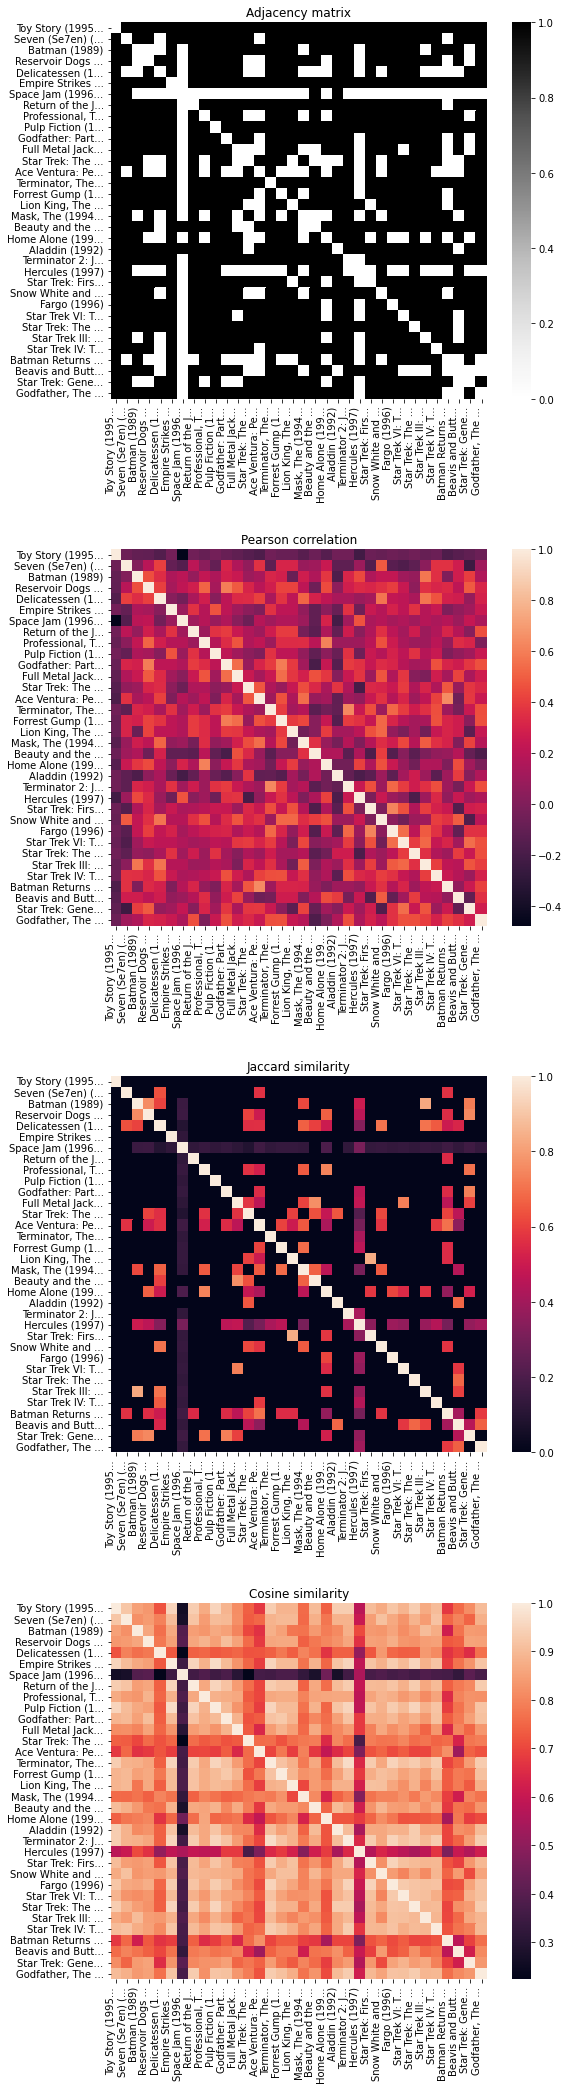

In [100]:
fig = plt.figure(figsize=(9, 9*4))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
cases = [[1, A, plt.cm.Greys, 'Adjacency matrix'], 
         [2, corr, None, 'Pearson correlation'], 
         [3, J, None, 'Jaccard similarity'], 
         [4, cos, None, 'Cosine similarity'], ]
for i, matrix, cmap, t in cases:
    plt.subplot(4, 1, i)
    hmap = sns.heatmap(
        matrix,
        cmap=cmap,
        square=True,
        yticklabels=[labs.get(i) for i in G.nodes])
    hmap.set_xticklabels(
        labels=[labs.get(i) for i in G.nodes], 
        horizontalalignment='right')
    plt.title(t)

### Task 2. Reordering of nodes (3 points)

Without special preprocess procedures an adjacency matrix can look very noisy and hide network's structure. There are some procedures of node reordering that provides a better view of the network's adjacency matrix. Reverse Cuthill-McKee finds permutation of the nodes that minimizes the bandwidth of the matrix, which is calculated as

$$ \theta = \max_{a_{ij} > 0}|i-j|$$

Unformally, this algorithm puts some mass on the diagonal of adjacency matrix. 

Write a function `cm_order` that takes a graph and returns a np.array with a permutation of the form $[i_1, i_2, \dots, i_n]$ where $i_1$ is an index of the first row and the first column.

Apply `scipy.sparse.csgraph.reverse_cuthill_mckee` or `nx.utils.reverse_cuthill_mckee_ordering`.

In [114]:
def cm_order(G):
  ordering = reverse_cuthill_mckee(csr_matrix(nx.to_numpy_array(G)))
  return np.asarray(ordering)


In [115]:
order = cm_order(G)
assert order.shape == (34,)
assert order[4:6].sum() < order[:3].sum() < order[4:7].sum()

Let us draw the heatmaps with a default and changed order side-by-side. A default order will be on the left, a changed order — on the right.

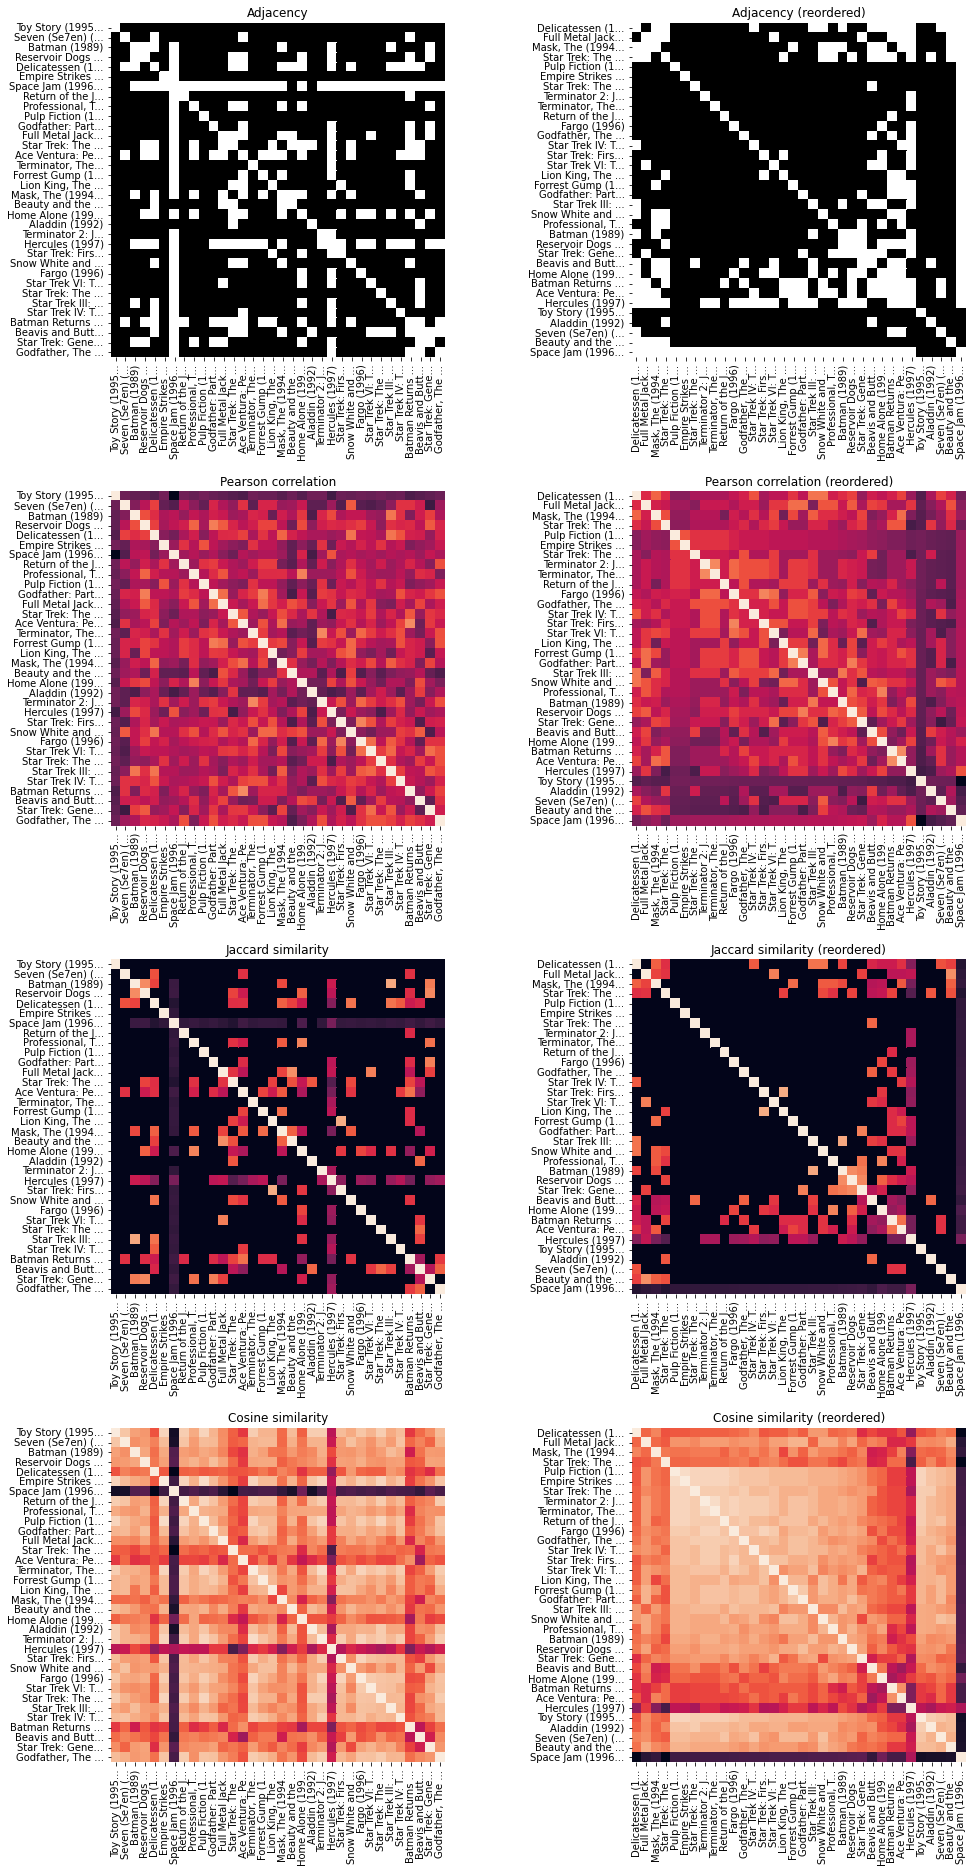

In [116]:
fig = plt.figure(figsize=(16, 16*2))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

cases = [[1, A, plt.cm.Greys, 'Adjacency', range(34)],
         [2, A, plt.cm.Greys, 'Adjacency (reordered)', order],
         [3, corr, None, 'Pearson correlation', range(34)], 
         [4, corr, None, 'Pearson correlation (reordered)', order], 
         [5, J, None, 'Jaccard similarity', range(34)], 
         [6, J, None, 'Jaccard similarity (reordered)', order], 
         [7, cos, None, 'Cosine similarity', range(34)], 
         [8, cos, None, 'Cosine similarity (reordered)', order]]

newLabs = np.array([labs.get(i) for i in G.nodes])

for i, matrix, cmap, t, o in cases:
    plt.subplot(4, 2, i)
    hmap = sns.heatmap(
        matrix[np.ix_(o, o)],
        cmap=cmap,
        cbar=False,
        square=True,
        yticklabels=newLabs[o])
    hmap.set_xticklabels(
        labels=newLabs[o], 
        rotation=90)
    plt.title(t)

We can observe that the right-hand heatmaps look smoother, and we can detect dense regions on them.

### Task 3. Assortative Mixing (3 points)

In this task, we look at the same dataset. One can find that graph have attribute `Genre`. Let us draw assortative mixing of a `Genre` attribute. How often persons from one house kills persons from another?

Write a function `genre_mixing` that takes a graph `G` and returns tuple with a matrix of assortative mixing `nx.attribute_mixing_matrix` by a `Genre` attribute and a dictionary with mapping of the form
* `{genre: index in the matrix}`

In [130]:
def genre_mixing(G):
    m_ofAssortativeMixing = attribute_mixing_matrix(G, "Genre")
    dic = {}
    for k , v in nx.get_node_attributes(G, "Genre").items():
      dic[v] = []
    for k , v in nx.get_node_attributes(G, "Genre").items():
      dic[v].append(k)
      
    return m_ofAssortativeMixing , dic
    # YOUR CODE HERE
    #raise NotImplementedError()

In [131]:
mixing, mapping = genre_mixing(G)
assert mixing.shape == (8, 8)
assert mixing.max() < 0.08
assert mixing.min() == 0
assert mapping.get("Comedy") is not None

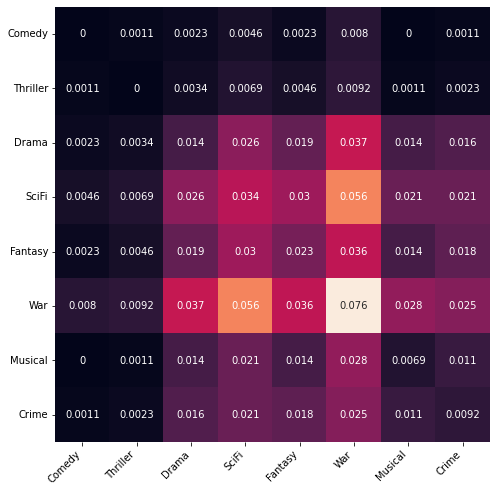

In [133]:
fig = plt.figure(figsize=(8, 8))
hmap = sns.heatmap(
    mixing,
    cbar=False,
    annot=True,
    square=True)
hmap.set_xticklabels(
    labels=[m for m in mapping], 
    rotation=45, 
    horizontalalignment='right')
hmap.set_yticklabels(
    labels=[m for m in mapping], 
    rotation=0)
plt.show()